> A basic introduction to using tile clustering

[![](https://colab.research.google.com/assets/colab-badge.svg "Open in Colab button")](https://colab.research.google.com/github/thinkingmachines/geowrangler/blob/master/notebooks/tutorial.tile_clustering.ipynb)

In [ ]:
#| include: false
#| no_test
! [ -e /content ] && pip install -Uqq geowrangler

In [ ]:
#| include: false
#| no_test
!mkdir -p ../data
![ -e /content ] && ln -s ../data .

In [ ]:
#| include: false
#| no_test
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#| include: false
from collections import deque
from typing import List, Optional, Tuple

import pandas as pd
from fastcore.basics import patch

## Summary
Clusters adjacent grid tiles together. Usage of this function assumes that the input is a grid dataset.

## How does it work? 
Tile clustering works by assigning the same ID to grid cells belonging to the same cluster. There are options to: (a) cluster adjacent cells by category, (b) cluster grid cells via adjacent edges or corners.

### `TileClustering().cluster_tiles(df, category_col)`



| | type | default| optional/required | details |
| --- | :--- | :--- | :--- | :--- |
| cluster_type | String | `four_way` | optional | Leave blank () if using `four_way` cluster_type (top, bottom, left, right sides of a cell). Put in `eight_way` if preference is to cluster via four sides and corners of a cell. |
| df | GeoDataFrame | *none* | required | dataframe for clustering |
| category_col | String | *none* |  optional | column for category if need to cluster adjacent cells by category |

A technical step-by-step explanation of how `TileClustering().cluster_tiles` works is detailed in the cell blocks below. An example on how to use it with its arguments is shown in the **sample use case** section thereafter. 

1. Define the class.

```
class TileClustering:
    def __init__(
        self,
        cluster_type: str = "four_way",
    ) -> None:

        assert cluster_type in ["four_way", "eight_way"]
        self.cluster_type = cluster_type
        self.tile_cluster_col = "tile_cluster"
```

2. Define the function.

```
@patch
def cluster_tiles(
    self: TileClustering,
    df: pd.DataFrame,
    grid_x_col="x",
    grid_y_col="y",
    category_col: Optional[str] = None,
) -> pd.DataFrame:
    """
    Appends the cluster ID for each square grid cell
    """

    if category_col is None:
        cluster_df = self._cluster_tiles_single(df, grid_x_col, grid_y_col)
    else:
        assert (
            not df[category_col].isnull().any()
        ), f"There shouldn't be null values for {category_col}"
        unique_categories = df[category_col].unique().tolist()

        cluster_df_list = []
        for i, category in enumerate(unique_categories, start=1):
            bool_mask = df[category_col] == category
            filtered_df = df.loc[bool_mask, :].copy()
            cluster_filtered_df = self._cluster_tiles_single(
                filtered_df, grid_x_col, grid_y_col
            )
            cluster_filtered_df[self.tile_cluster_col] = cluster_filtered_df[
                self.tile_cluster_col
            ].apply(lambda key: f"{key}-{i}")
            cluster_df_list.append(cluster_filtered_df)
        cluster_df = pd.concat(cluster_df_list, axis=0, ignore_index=True)

    df = pd.merge(left=df, right=cluster_df, on=[grid_x_col, grid_y_col], how="left")

    return df
```

3) Categorize commands depending on input of `category_col`. Append cluster ID for each grid cell. 

```
    # no entry in category_col - run the patched function _cluster_tiles_single
    if category_col is None:
        cluster_df = self._cluster_tiles_single(df, grid_x_col, grid_y_col)

    # entry in category_col - make sure that all rows have values
    else:
        assert (
            not df[category_col].isnull().any()
        ), f"There shouldn't be null values for {category_col}"
        unique_categories = df[category_col].unique().tolist()

    # append cluster ID for each grid cell
        cluster_df_list = []
        for i, category in enumerate(unique_categories, start=1):
            bool_mask = df[category_col] == category
            filtered_df = df.loc[bool_mask, :].copy()
            cluster_filtered_df = self._cluster_tiles_single(
                filtered_df, grid_x_col, grid_y_col
            )
            cluster_filtered_df[self.tile_cluster_col] = cluster_filtered_df[
                self.tile_cluster_col
            ].apply(lambda key: f"{key}-{i}")
            cluster_df_list.append(cluster_filtered_df)
        cluster_df = pd.concat(cluster_df_list, axis=0, ignore_index=True)
```        

4) Merge grid cells with same cluster ID.   

```
    df = pd.merge(left=df, right=cluster_df, on=[grid_x_col, grid_y_col], how="left")
```

5) Return output dataframe. 

```
    return df
```

6) Other `@patch` functions

`_cluster_tiles_single` - called when there is no entry in `category_col`

```
@patch
def _cluster_tiles_single(
    self: TileClustering,
    df: pd.DataFrame,
    grid_x_col="x",
    grid_y_col="y",
) -> pd.DataFrame:
    """
    Performs tile clustering on a single category
    """

    if self.tile_cluster_col in df.columns:
        raise ValueError(
            f"{self.tile_cluster_col} already exists as a column. Please rename"
        )

    grid_x = df[grid_x_col]
    grid_y = df[grid_y_col]

    self.grid_idx = set(zip(grid_x, grid_y))

    self.tile_cluster_dict = {}
    self.cluster_id = 0

    for key in self.grid_idx:
        if key not in self.tile_cluster_dict.keys():
            self.cluster_id += 1

            # reset the call stack per iteration
            self.call_stack = deque()
            self._dfs_connected_components(key)

    cluster_df = pd.DataFrame.from_dict(
        self.tile_cluster_dict, orient="index", columns=[self.tile_cluster_col]
    )
    cluster_df = cluster_df.reset_index()
    cluster_df[grid_x_col] = cluster_df["index"].apply(lambda idx: idx[0])
    cluster_df[grid_y_col] = cluster_df["index"].apply(lambda idx: idx[1])
    cluster_df = cluster_df.drop(columns="index")

    return cluster_df
```

`_get_adjacent_keys` - defines how `four_way` and `eight_way` clustering works

```
@patch
def _get_adjacent_keys(
    self: TileClustering,
    key: Tuple[int, int],
) -> List[Tuple[int, int]]:

    x_idx = key[0]
    y_idx = key[1]

    east_key = (x_idx + 1, y_idx)
    west_key = (x_idx - 1, y_idx)
    south_key = (x_idx, y_idx - 1)
    north_key = (x_idx, y_idx + 1)

    if self.cluster_type == "four_way":
        adjacent_keys = [east_key, west_key, south_key, north_key]

    if self.cluster_type == "eight_way":
        northeast_key = (x_idx + 1, y_idx + 1)
        northwest_key = (x_idx - 1, y_idx + 1)
        southeast_key = (x_idx + 1, y_idx - 1)
        southwest_key = (x_idx - 1, y_idx - 1)

        adjacent_keys = [
            east_key,
            west_key,
            south_key,
            north_key,
            northeast_key,
            northwest_key,
            southeast_key,
            southwest_key,
        ]

    return adjacent_keys
```

`_dfs_connected_components` - a non-recursive depth-first search implementation of connected components 

```
@patch
def _dfs_connected_components(
    self: TileClustering,
    key: Tuple[int, int],
) -> None:

    self.call_stack.append(key)
    while self.call_stack:
        ref_key = self.call_stack.pop()

        # check if key exists in the first place
        if ref_key in self.grid_idx:
            # check if adjacent key has already been assigned
            if ref_key not in self.tile_cluster_dict.keys():
                self.tile_cluster_dict[ref_key] = self.cluster_id

                adjacent_keys = self._get_adjacent_keys(ref_key)
                for adjacent_key in adjacent_keys:
                    self.call_stack.append(adjacent_key)
```

## Sample use case- Clustering areas based on scores

Input:
- `grid_gdf5k` - GeoDataFrame of randomly scored 5km x 5km grid cells
- `class` - category column for basis of of clustering

Output:
- clustered grid based on `class`

### Step 1: Import packages

In [ ]:
#| include: false
from collections import deque
from typing import List, Optional, Tuple

import pandas as pd
from fastcore.basics import patch

In [ ]:
import geopandas as gpd
import numpy as np

import geowrangler.grids as grids

import geowrangler.tile_clustering as tile_clustering

### Step 2: Load GeoDataFrame and generate grid

In [ ]:
#| include: false
#| no_test
!mkdir -p ../data
# download sample geojson file from repo
![ ! -e ../data/region3_admin.geojson ] && curl -s -o ../data/region3_admin.geojson https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/region3_admin.geojson

In [ ]:
#| include: false
region3_gdf = gpd.read_file("../data/region3_admin.geojson")

In [ ]:
grid_generator5k = grids.SquareGridGenerator(5_000)
grid_gdf5k = grid_generator5k.generate_grid(region3_gdf)

In [ ]:
#| no_test
grid_gdf5k

,x,y,geometry
0,7,8,"POLYGON ((120.10024 14.75528, 120.14516 14.755..."
1,6,8,"POLYGON ((120.05533 14.75528, 120.10024 14.755..."
2,9,8,"POLYGON ((120.19008 14.75528, 120.23499 14.755..."
3,2,24,"POLYGON ((119.87566 15.4491, 119.92058 15.4491..."
4,2,25,"POLYGON ((119.87566 15.49239, 119.92058 15.492..."
...,...,...,...
1069,54,44,"POLYGON ((122.21128 16.31312, 122.2562 16.3131..."
1070,54,45,"POLYGON ((122.21128 16.35623, 122.2562 16.3562..."
1071,54,46,"POLYGON ((122.21128 16.39932, 122.2562 16.3993..."
1072,54,47,"POLYGON ((122.21128 16.4424, 122.2562 16.4424,..."


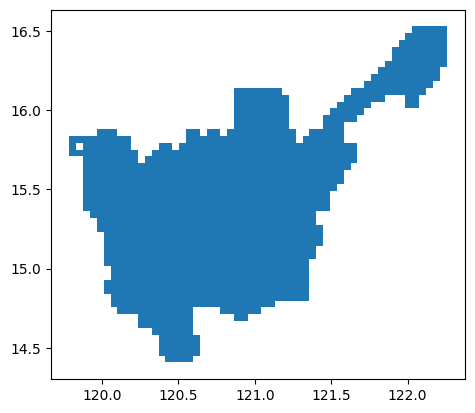

In [ ]:
#| no_test
grid_gdf5k.plot();

### Step 3: Assign scores

In [ ]:
#| include: false
grid_gdf5k["score"] = np.random.random(len(grid_gdf5k))
grid_gdf5k["class"] = grid_gdf5k["score"] > 0.7

In [ ]:
#| no_test
grid_gdf5k

,x,y,geometry,score,class
0,7,8,"POLYGON ((120.10024 14.75528, 120.14516 14.755...",0.216056,False
1,6,8,"POLYGON ((120.05533 14.75528, 120.10024 14.755...",0.198387,False
2,9,8,"POLYGON ((120.19008 14.75528, 120.23499 14.755...",0.508601,False
3,2,24,"POLYGON ((119.87566 15.4491, 119.92058 15.4491...",0.186705,False
4,2,25,"POLYGON ((119.87566 15.49239, 119.92058 15.492...",0.383824,False
...,...,...,...,...,...
1069,54,44,"POLYGON ((122.21128 16.31312, 122.2562 16.3131...",0.059555,False
1070,54,45,"POLYGON ((122.21128 16.35623, 122.2562 16.3562...",0.824039,True
1071,54,46,"POLYGON ((122.21128 16.39932, 122.2562 16.3993...",0.903166,True
1072,54,47,"POLYGON ((122.21128 16.4424, 122.2562 16.4424,...",0.186872,False


### Step 4: Tile clustering

In [ ]:
#| no_test
output = tile_clustering.TileClustering().cluster_tiles(
    df=grid_gdf5k, category_col="class"
)

In [ ]:
#| no_test
output

,x,y,geometry,score,class,tile_cluster
0,7,8,"POLYGON ((120.10024 14.75528, 120.14516 14.755...",0.216056,False,1-1
1,6,8,"POLYGON ((120.05533 14.75528, 120.10024 14.755...",0.198387,False,1-1
2,9,8,"POLYGON ((120.19008 14.75528, 120.23499 14.755...",0.508601,False,1-1
3,2,24,"POLYGON ((119.87566 15.4491, 119.92058 15.4491...",0.186705,False,1-1
4,2,25,"POLYGON ((119.87566 15.49239, 119.92058 15.492...",0.383824,False,1-1
...,...,...,...,...,...,...
1069,54,44,"POLYGON ((122.21128 16.31312, 122.2562 16.3131...",0.059555,False,2-1
1070,54,45,"POLYGON ((122.21128 16.35623, 122.2562 16.3562...",0.824039,True,33-2
1071,54,46,"POLYGON ((122.21128 16.39932, 122.2562 16.3993...",0.903166,True,33-2
1072,54,47,"POLYGON ((122.21128 16.4424, 122.2562 16.4424,...",0.186872,False,2-1


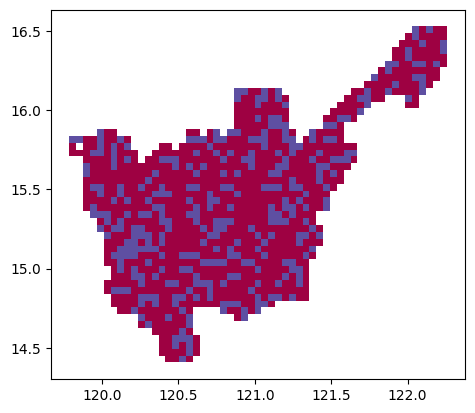

In [ ]:
#| no_test
output.plot(column="class", categorical=True, cmap="Spectral");